# Gaussian Processes to Predict Stock Prices

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
#get weekly change
def get_series(stock, start, end):
    data = web.DataReader(stock, 'yahoo', start, end)['Adj Close']
    return data.resample('W-FRI').last().diff()[1:]

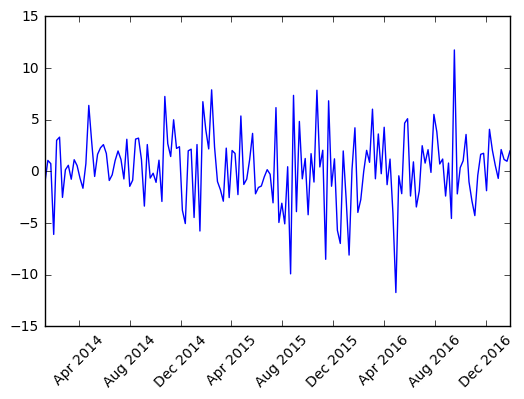

In [106]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime.today();
TS = get_series("AAPL", start, end);
plt.plot(TS); plt.xticks(rotation=45);

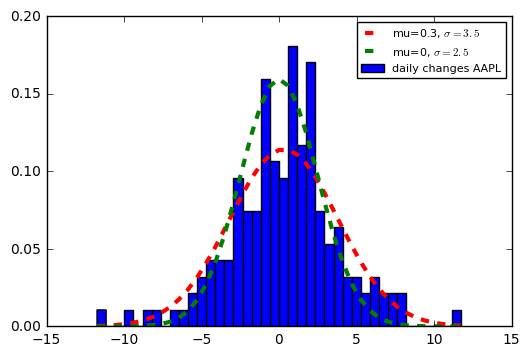

In [107]:
import matplotlib.mlab as mlab
from scipy.stats import norm
(mu, sigma) = norm.fit(TS)
n, bins, junk = plt.hist(TS, 40, normed=True, label='daily changes AAPL');
plt.plot(bins,mlab.normpdf( bins, mu, sigma), 'r--', lw=3, label='mu=%.1f, $\sigma=%.1f$'%(mu,sigma))
plt.plot(bins,mlab.normpdf( bins, 0, 2.5), 'g--', lw=3, label=r'mu=0, $\sigma=2.5$')
plt.legend(fontsize=8)

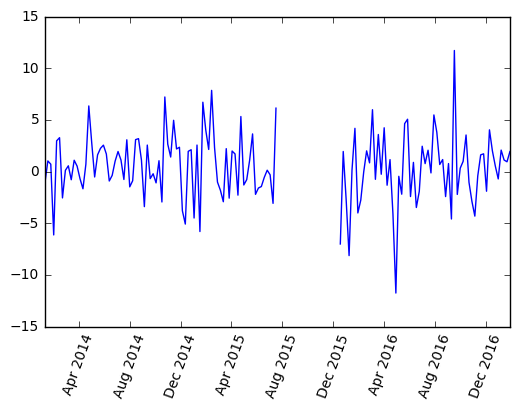

In [108]:
skip1, skip2 = 80, 100
days = np.concatenate((np.arange(len(TS))[0:skip1], np.arange(len(TS))[skip2:]))
missing_days = np.arange(skip1, skip2, 1)
TS2 = TS.iloc[0:skip1].append(TS.iloc[skip2:])
plt.plot(TS2[0:skip1]); plt.plot(TS2[skip1+1:], color='blue'); plt.xticks(rotation=70);

## Understanding GPs
- Prior is affected by kernel used. Drawing functions from an N-dimensional gaussian, where N is the  number of data points.  
- In general, the GP function is mean reverting. Since you are drawing samples from an N-dimensional gaussian, whatever the mean of your data is, in between data points the GP will head towards that mean, since probabilistically speaking the mean of your data is the most likely.
- So, you need to have GP on the rolling difference of stock prices!!! Those are supposed to be gaussian distributed.

In [3]:
import george
from george import kernels

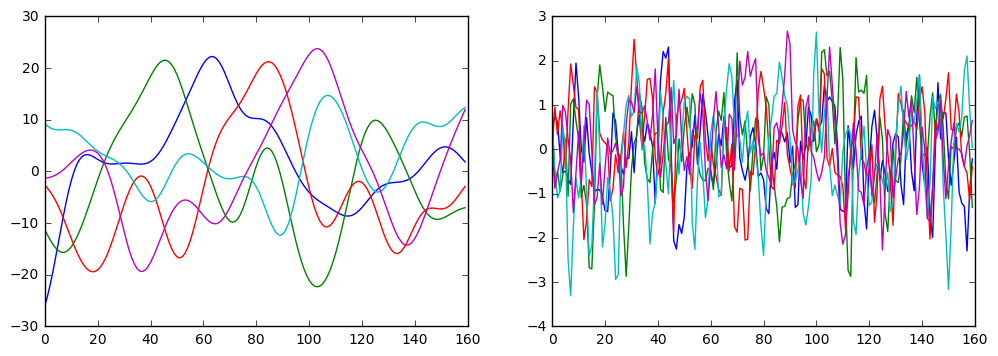

In [93]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 2, 1)
a, l = 100, 100
gp = george.GP(a*kernels.ExpSquaredKernel(l))
for i in range(5):
    ax.plot(gp.sample(np.arange(len(TS))), '-')

ax = fig.add_subplot(1, 2, 2)
a, l = 1, 1
gp = george.GP(a*kernels.ExpSquaredKernel(l))
for i in range(5):
    ax.plot(gp.sample(np.arange(len(TS))), '-')

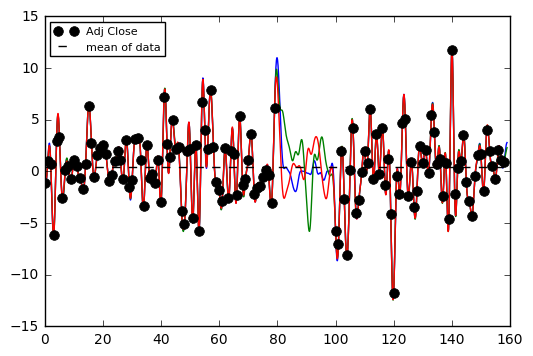

In [104]:
Nmax = 139

times = np.linspace(0,days[Nmax],Nmax*20)
#data = ((TS2[:Nmax] - TS2[:Nmax].mean()) / TS2[:Nmax].std()).values
data = TS2[:Nmax]

#a, l = 1e-1,1e-1     #not terrible values
a, l = 2, 1
gp = george.GP(a*kernels.ExpSquaredKernel(l), mean=np.mean(data))
#gp = george.GP(a*kernels.Matern32Kernel(l))

#show GP on existing data
gp.compute(days[:Nmax])
fig, ax = plt.subplots()
for pred in gp.sample_conditional(data, times, 3):
    ax.plot(times, pred)
ax.plot(days[:Nmax], data, 'ko', markersize=7)
ax.plot([0,days[Nmax]], [np.mean(data), np.mean(data)], 'k--', markersize=7, label='mean of data')
ax.legend(loc='upper left', fontsize=8)

#predict on the new data
#N_points
#mu, cov = gp.predict(TS2[], )
#std = np.sqrt(np.diag(cov))
#plt.plot(missing_days, mu, '-', c='#fb6a4a', lw=2)

In [99]:
a,l = 1, 1e-3
gp = george.GP(a*kernels.ExpSquaredKernel(l), mean=np.mean(TS2))
gp.compute(days)

params = [(x,y) for x in np.logspace(-4,1,10) for y in np.logspace(-4,1,10)]
for p in params:
    gp.kernel[:] = p
    gp.compute(days)
    mu, cov = gp.predict(TS2, missing_days)
    std = np.sqrt(np.diag(cov))
    plt.plot(missing_days, mu, '-', c='#fb6a4a', lw=2)
    plt.plot(days[0:skip1], TS2[0:skip1]); plt.plot(days[skip1+1:], TS2[skip1+1:], color='blue')
    plt.savefig("plots/a=%.2e_l=%.2e.png"%p)
    plt.clf()

LinAlgError: 30-th leading minor not positive definite

## Optimize

In [102]:
a, l, = 0.1, 0.1
gp = george.GP(a * kernels.ExpSquaredKernel(l))
gp.optimize(days, TS2)

Optimization terminated successfully.


(array([ 2.37219961, -3.78057212]),
       fun: 364.70536758431217
 hess_inv: array([[ 0.01428208, -0.0074276 ],
       [-0.0074276 ,  0.99869819]])
      jac: array([ -5.75955792e-08,  -7.86175758e-09])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([ 2.37219961, -3.78057212]))

## emcee

In [75]:
import emcee

In [76]:
def lnprob(p):
    a, l = p
    if 0>a>100 or 0>l>100:     # Trivial uniform prior.
        return -np.inf
    lnprior = 0.0

    kernel.pars = p            # Update the kernel and compute the lnlikelihood.
    return lnprior + gp.lnlikelihood(TS2, quiet=True)

In [4]:
a,l = 1, 1
gp = george.GP(a*kernels.ExpSquaredKernel(l))
gp.compute(days)

NameError: name 'days' is not defined

In [88]:
nwalkers, ndim = 36, 2
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [np.log(kernel.pars) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

p0, _, _ = sampler.run_mcmc(p0, 500)

Running burn-in


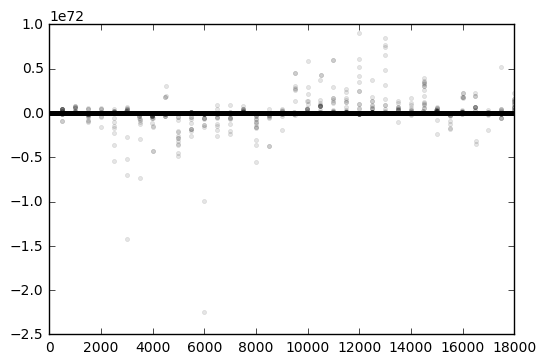

In [89]:
samples = sampler.chain.reshape((-1, ndim))
plt.plot(samples[:,0], '.', alpha=0.1, color='black')

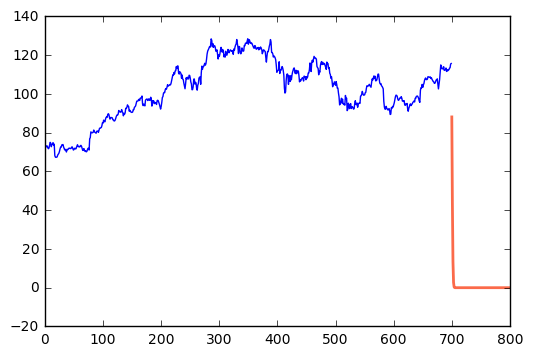

In [17]:
mu, cov = gp.predict(TS2, missing_days)  # give data to evaluate likelihood for missing days
std = np.sqrt(np.diag(cov))
plt.plot(days[0:skip1], TS2[0:skip1]); plt.plot(days[skip1+1:], TS2[skip1+1:], color='blue')
plt.plot(missing_days, mu, '-', c='#fb6a4a', lw=2)
#plt.fill_between(missing_days, mu-std, mu+std, color='#fb6a4a', alpha=.5)

## EXTRA

In [5]:
import numpy as np
import statsmodels.api as sm

data = sm.datasets.get_rdataset("co2").data
t = np.array(data.time)
y = np.array(data.co2)

In [8]:
k1 = 66.0**2 * kernels.ExpSquaredKernel(67.0**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(2.0 / 1.3**2, 1.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(0.78, 1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2) + kernels.WhiteKernel(0.19)
#kernel = k1 + k2 + k3 + k4
kernel = k1 + k2 + k3
print len(kernel)

9


In [9]:
gp = george.GP(kernel, mean=np.mean(y))
gp.compute(t)

LinAlgError: 47-th leading minor not positive definite